
<h1>Содержание<span class="tocSkip"></span></h1>

<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords


import torch
import transformers
import spacy

from pymystem3 import Mystem
m = Mystem() 
import re 
from sklearn.feature_extraction.text import CountVectorizer 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

In [214]:
# Install spaCy (run in terminal/prompt)
#import sys
#!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
#!{sys.executable} -m spacy download en

In [ ]:
#nltk.download('stopwords') 

Табличка для записи метрик

In [3]:
d = {'F1 обучения': [], 'F1 предсказания':[]}   
          
summary_table = pd.DataFrame(data=d)
def write_summary_table (col, row, f):
    if row == 0:
        row = 'F1 обучения'
    if row == 1:
        row = 'F1 предсказания'    
    summary_table.loc[col, row] = f

## Подготовка

In [5]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')


Изучим данные таблицы. 

In [21]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [22]:
toxic_comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Таблица содержит 159571  строк текста на английском языке со служебными символами. Необходимо очистить их от лишнего и лемматизировать.

Функция, оставляющая только буквы

In [23]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z]', ' ', text)        
    clear = clear.split()
    clear_text = " ".join(clear)
    return clear_text

Для лемматизации будем использовать модуль spacy.

In [24]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_spacy(sentence):    
    doc = nlp(sentence)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text

In [25]:
toxic_comments['clear_text'] = toxic_comments['text'].apply(lambda x: clear_text(x))

In [26]:
%%time
start = time.time()
toxic_comments['lemm_text'] = toxic_comments['clear_text'].apply(lambda x: lemmatize_spacy(x))
end = time.time()
print(end-start)

3302.5543735027313
CPU times: user 48min 41s, sys: 9.62 s, total: 48min 51s
Wall time: 55min 2s


Итоги запишем себе в файл, чтобы не пересчитывать. 

In [27]:
toxic_comments.to_csv('lemm_text.csv', index=False)

In [23]:
toxic_comments = pd.read_csv('lemm_text.csv')

In [24]:
print("Исходный текст:", toxic_comments['text'][0])
print("Лемматизированный текст:", toxic_comments['lemm_text'][0])

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизированный текст: explanation why the edit make under -PRON- username Hardcore Metallica Fan be revert -PRON- weren t vandalism just closure on some gas after -PRON- vote at New York Dolls FAC and please don t remove the template from the talk page since -PRON- m retire now


Получили текст, готовый к анализу. 

Рассмотрим распределение целевого признака.

0    143346
1     16225
Name: toxic, dtype: int64


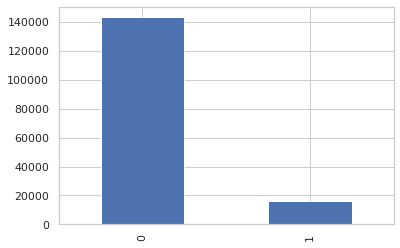

In [26]:
class_frequency = toxic_comments['toxic'].value_counts()
print(class_frequency)
class_frequency.plot(kind='bar') 

Признак не сбалансирован, что может помешать обучению модели. Количество позитивных комментариев в девять раз больше негативных.

### TF-IDF ###

Для обучения модели преобразуем тексты в векторную форму. <br>
Столбец признаков будет являться корпусом слов, который мы трансформируем в матрицу и посчитаем величину TF-IDF.

Создадим переменные для признака и целевого признака.

In [27]:
toxic_comments = toxic_comments.dropna()

In [28]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159564 entries, 0 to 159570
Data columns (total 4 columns):
text          159564 non-null object
toxic         159564 non-null int64
clear_text    159564 non-null object
lemm_text     159564 non-null object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


In [29]:
features = toxic_comments['lemm_text']
target = toxic_comments['toxic']

Разобьем датасет на обучающую и тестовую выборку в соотношении 80-20

In [30]:
train_corpus, test_corpus, target_train, target_test = train_test_split(features,target,test_size=0.2)

print('Размер обучающей выборки:', len(train_corpus))
print('Размер тестовой выборки:', len(test_corpus))

Размер обучающей выборки: 127651
Размер тестовой выборки: 31913


Создадим счётчик стоп-слов (слов без смысловой нагрузки)

In [31]:
stopwords = set(nltk_stopwords.words('english'))

Создадим счетчик tf_idf, который выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса. 

In [32]:
tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=True, min_df=0.0001)
features_train = tf_idf.fit_transform(train_corpus)
features_test = tf_idf.transform(test_corpus)


In [33]:
features_train.shape

(127651, 13312)

In [34]:
target_train.shape

(127651,)

## Обучение моделей ##

Рассмотрим результат работы модели без балансировки классов. Для эксперимента возьмем логистическую регрессию. 

In [36]:
model = LogisticRegression()
parameters = {'solver': ['liblinear']}

grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_train, target_train)
predicted_test = grid.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.7572989432204907


Метрика f1 достигла 75, что в принципе является минимальным допустимым для нас результатом. 

<div class="alert alert-block alert-info">
<b>Совет: </b> Напомню, что внутри кросс-валидации происходих разбиение выборки на треин и валидацию. Однако, в таком случае векторизатор обучен на всей выборке, а это не совсем корректно. Для избежания такого эффекта можно использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">пайплайн</a>.
</div>

Попробуем увеличить качество модели с помощью взвешивания классов.

In [37]:
model = LogisticRegression()
parameters = {'solver': ['liblinear'], 'class_weight': ['balanced']}
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_train, target_train)
predicted_test = grid.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.7360308285163776


Лучше не стало

Попробуем уменьшить число позитивных комментариев. Можно было бы увеличить число отрицательных, но датасет слишком разрастется. <br>
Если приравнять число позитивных комментариев к негативным, мы потеряем большую часть данных. <br>
Попробуем отрезать только часть позитивных, например, оставим одну треть из них. <br>

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled)
    
    return features_downsampled, target_downsampled

In [45]:
features_downsampled, target_downsampled = downsample(train_corpus, target_train, 0.3)

In [46]:
tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=True, min_df=0.0001)
features_downsampled = tf_idf.fit_transform(features_downsampled)
features_test = tf_idf.transform(test_corpus)

0    34419
1    12921
Name: toxic, dtype: int64


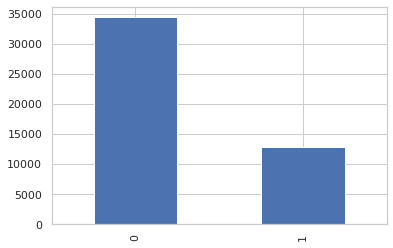

In [47]:
class_frequency = target_downsampled.value_counts(normalize=False)
print(class_frequency)
class_frequency.plot(kind='bar') 

Далее обучим модели на признаках features_downsampled

### LogisticRegression ###

In [62]:
model = LogisticRegression()
parameters = {'solver': ['liblinear']}

In [63]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

write_summary_table('LogisticRegression', 0, grid.best_score_)

0.8131030961259177
{'solver': 'liblinear'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [64]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('LogisticRegression', 1, f1)

0.7733623098416641


### LGBMClassifier ###

In [51]:
model = LGBMClassifier()
parameters = {
   # 'objective':['binary'],
    #'num_leaves': [31]
    'n_estimators': [100]
     
}

In [52]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

write_summary_table('LGBM', 0, grid.best_score_)


0.8232249500772805
{'n_estimators': 100}
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [53]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('LGBM', 1, f1)

0.7768930523028884


###  CatBoost ### 

In [54]:
model = CatBoostClassifier()

parameters = {    
   # 'learning_rate': [0.1],
    'iterations': [100], #[40, 60, 100, 200, 500]
    #depth': [10],  #[5, 7, 10]    
    'verbose': [200]
}


In [55]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
write_summary_table('CatBoost', 0, grid.best_score_)

Learning rate set to 0.346242
0:	learn: 0.5465961	total: 1.57s	remaining: 2m 35s
99:	learn: 0.2008827	total: 2m 4s	remaining: 0us
Learning rate set to 0.346242
0:	learn: 0.5503247	total: 1.38s	remaining: 2m 17s
99:	learn: 0.2027491	total: 2m 5s	remaining: 0us
Learning rate set to 0.346242
0:	learn: 0.5428245	total: 1.23s	remaining: 2m 2s
99:	learn: 0.2020647	total: 2m 4s	remaining: 0us
Learning rate set to 0.388341
0:	learn: 0.5269324	total: 2.11s	remaining: 3m 28s
99:	learn: 0.2011569	total: 2m 44s	remaining: 0us
0.812264866260424
{'iterations': 100, 'verbose': 200}


In [56]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('CatBoost', 1, f1)

0.7710843373493977


### DecisionTreeClassifier ###

In [58]:
model = DecisionTreeClassifier()

parameters = {'max_depth': range(4,16,2)}

In [59]:

grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
write_summary_table('DecisionTreeClassifier', 0, grid.best_score_)

0.6602913478860803
{'max_depth': 14}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [60]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('DecisionTreeClassifier', 1, f1)

0.6433748373908196


In [65]:
summary_table

,F1 обучения,F1 предсказания
LogisticRegression,0.813103,0.773362
LGBM,0.823225,0.776893
CatBoost,0.812265,0.771084
DecisionTreeClassifier,0.660291,0.643375


## BERT ##

https://colab.research.google.com/drive/1EFARdmEiY76uqLP0BCtWZchlF9c3kN1u?usp=sharing

## Выводы

Мы лемматизировали текст, трансформировали текстовую колонку в матрицу и посчитали величину TF-IDF. <br>
Обучили модели классифицировать комментарии на позитивные и токсичные.  <br>
Лучшие результаты показала модель логистической регрессии, для нее достаточным оказалось только очистить и лемматизировать исходные данные, чтобы получить метрику качества F1 выше 0,75<br>
На уменьшенной выборке хорошие метрики оказались у моделей классификации CatBoost (0,77) и LGBM (0,77). 